<a href="https://colab.research.google.com/github/VIGNESHK-2564/ML-Project/blob/main/CBLAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install prophet yfinance statsmodels matplotlib scikit-learn


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.vector_ar.var_model import VAR


In [ ]:
# Load Tesla & Apple data
tesla = yf.download('TSLA', start='2015-01-01', end='2023-12-31')
apple = yf.download('AAPL', start='2015-01-01', end='2023-12-31')

# Reset index and keep only date and close
tesla = tesla[['Close']].reset_index()
tesla.columns = ['ds', 'y']

apple = apple[['Close']].reset_index()
apple.columns = ['ds', 'y']


/tmp/ipython-input-3-3473075103.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tesla = yf.download('TSLA', start='2015-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-3473075103.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  apple = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


**PROPHET MODEL**

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0_yulrge/9nsxl059.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0_yulrge/poa8f4hl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47106', 'data', 'file=/tmp/tmp0_yulrge/9nsxl059.json', 'init=/tmp/tmp0_yulrge/poa8f4hl.json', 'output', 'file=/tmp/tmp0_yulrge/prophet_modelkqrbk11w/prophet_model-20250625204625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


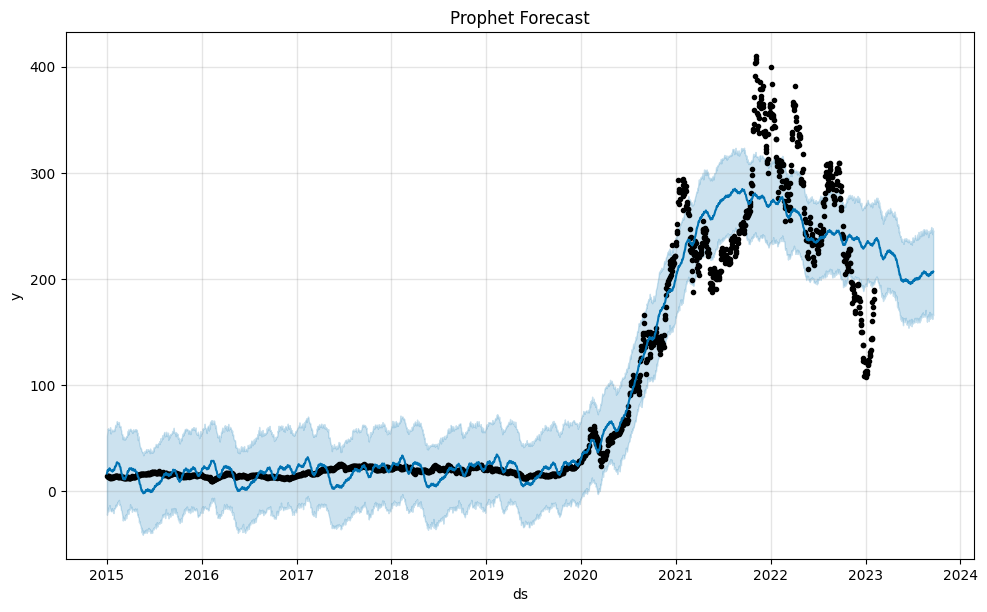

In [ ]:
# Train-test split
train_size = int(len(tesla)*0.9)
train = tesla[:train_size]
test = tesla[train_size:]

# Model
model_prophet = Prophet()
model_prophet.fit(train)

# Future dataframe and prediction
future = model_prophet.make_future_dataframe(periods=len(test))
forecast = model_prophet.predict(future)

# Plot forecast
model_prophet.plot(forecast)
plt.title('Prophet Forecast')
plt.show()


In [ ]:
pred = forecast[['ds', 'yhat']].iloc[-len(test):]
y_true = test['y'].values
y_pred = pred['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'Prophet MAE: {mae}')
print(f'Prophet MSE: {mse}')
print(f'Prophet RMSE: {rmse}')
print(f'Prophet MAPE: {mape}')


Prophet MAE: 43.72047032328148
Prophet MSE: 2270.621994724499
Prophet RMSE: 47.65104400455985
Prophet MAPE: 19.5576704035113


In [ ]:
tesla = yf.download('TSLA', start='2015-01-01', end='2023-12-31')
tesla = tesla[['Close']].rename(columns={'Close': 'y'})
tesla.index = pd.to_datetime(tesla.index)


/tmp/ipython-input-14-2772806479.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tesla = yf.download('TSLA', start='2015-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


**Classical Decomposition**

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
# Perform decomposition
decomposition = seasonal_decompose(tesla['y'], model='additive', period=252)  # 252 trading days ~ 1 year


<Figure size 1200x1000 with 0 Axes>

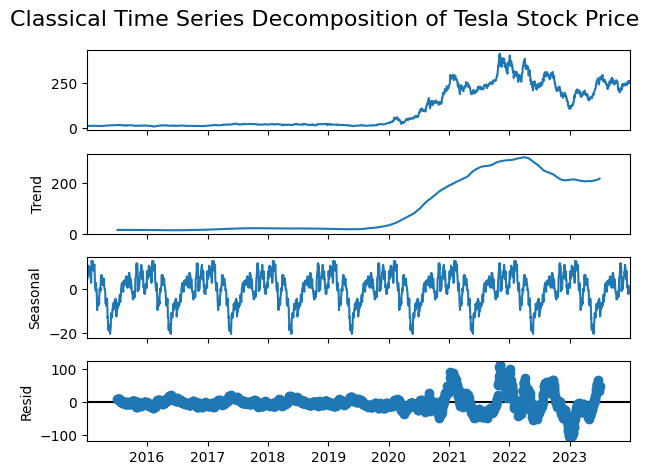

In [ ]:
# Plot decomposition
plt.figure(figsize=(12, 10))
decomposition.plot()
plt.suptitle('Classical Time Series Decomposition of Tesla Stock Price', fontsize=16)
plt.tight_layout()
plt.show()


**Stationarity test**

In [ ]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# ADF Test function
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic :', result[0])
    print('p-value       :', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print("✅ Series is Stationary")
    else:
        print("❌ Series is NOT Stationary")

# Run test on original Tesla closing price
adf_test(tesla['y'])


ADF Statistic : -1.0815709783181922
p-value       : 0.7223649564823023
Critical Values:
   1%: -3.43327791728229
   5%: -2.8628334711844436
   10%: -2.56745857614543
❌ Series is NOT Stationary


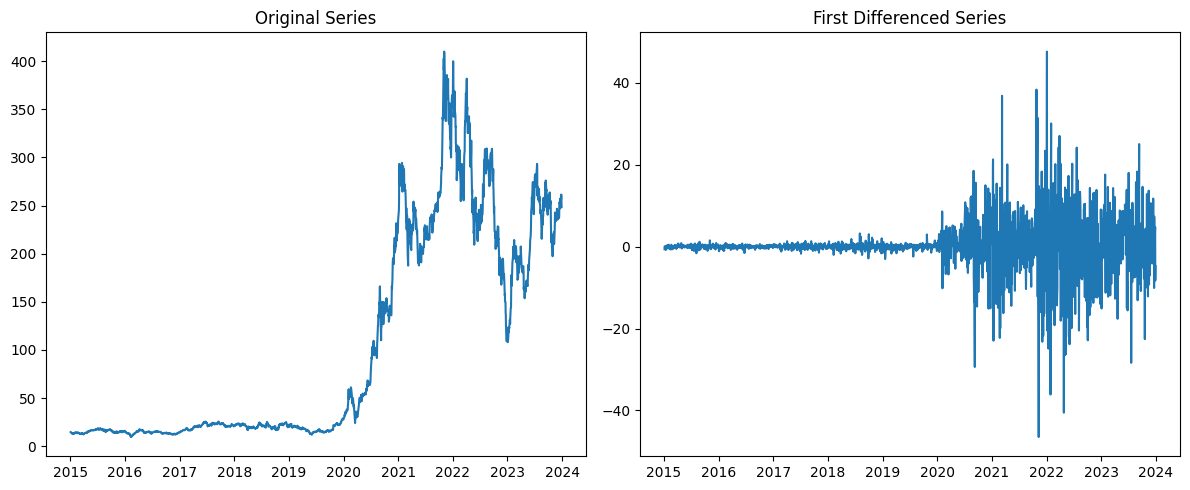

In [ ]:
# First Order Differencing
tesla_diff = tesla['y'].diff().dropna()

# Plot original vs differenced
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(tesla['y'])
plt.title('Original Series')

plt.subplot(1, 2, 2)
plt.plot(tesla_diff)
plt.title('First Differenced Series')

plt.tight_layout()
plt.show()


In [ ]:
adf_test(tesla_diff)


ADF Statistic : -9.534725626008978
p-value       : 2.828757989867017e-16
Critical Values:
   1%: -3.4332792288216227
   5%: -2.8628340503010357
   10%: -2.567458884484683
✅ Series is Stationary


**ARIMA**

In [ ]:
model_arima = ARIMA(train['y'], order=(5,1,2))  # example: AR=5, I=1, MA=2

model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=len(test))

# Evaluation
mae_arima = mean_absolute_error(test['y'], forecast_arima)
mse_arima = mean_squared_error(test['y'], forecast_arima)
rmse_arima = sqrt(mse_arima)
mape_arima = np.mean(np.abs((test['y'] - forecast_arima) / test['y'])) * 100

print(f'ARIMA MAE: {mae_arima}')
print(f'ARIMA MSE: {mse_arima}')
print(f'ARIMA RMSE: {rmse_arima}')
print(f'ARIMA MAPE: {mape_arima}')
print(f'ARIMA AIC: {model_arima_fit.aic}')
print(f'ARIMA BIC: {model_arima_fit.bic}')


ARIMA MAE: 40.42087509009516
ARIMA MSE: 2334.948795666775
ARIMA RMSE: 48.32130788448068
ARIMA MAPE: 16.757373386265794
ARIMA AIC: 12726.160767758598
ARIMA BIC: 12771.110706779962


**SARIMA**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(train['y'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12))  # You can adjust these
sarima_fit = model_sarima.fit()

# Forecast
forecast_sarima = sarima_fit.forecast(steps=len(test))

# Evaluation
mae_sarima = mean_absolute_error(test['y'], forecast_sarima)
mse_sarima = mean_squared_error(test['y'], forecast_sarima)
rmse_sarima = sqrt(mse_sarima)
mape_sarima = np.mean(np.abs((test['y'] - forecast_sarima) / test['y'])) * 100

print(f'\nSARIMA MAE: {mae_sarima}')
print(f'SARIMA MSE: {mse_sarima}')
print(f'SARIMA RMSE: {rmse_sarima}')
print(f'SARIMA MAPE: {mape_sarima}')
print(f'SARIMA AIC: {sarima_fit.aic}')
print(f'SARIMA BIC: {sarima_fit.bic}')



SARIMA MAE: 32.752791385441334
SARIMA MSE: 1560.5082413958035
SARIMA RMSE: 39.50326874317875
SARIMA MAPE: 13.780563444668648
SARIMA AIC: 12745.023117184915
SARIMA BIC: 12773.087272336952


**VARIMA**

In [ ]:
# Merge both datasets
combined = pd.merge(tesla, apple, on='ds', suffixes=('_tesla', '_apple'))
combined = combined.set_index('ds')

# Train VAR model
model_var = VAR(combined[['y_tesla', 'y_apple']])
train_var = combined[:-30]
model_fitted = model_var.fit(maxlags=15, ic='aic')

# Forecast 30 days
forecast_input = train_var.values[-model_fitted.k_ar:]
forecast_var = model_fitted.forecast(y=forecast_input, steps=30)
forecast_df = pd.DataFrame(forecast_var, columns=['y_tesla_pred', 'y_apple_pred'])

# Actual Apple values
actual_apple = combined['y_apple'][-30:].values

# Evaluation for Apple
mae_var = mean_absolute_error(actual_apple, forecast_df['y_apple_pred'])
mse_var = mean_squared_error(actual_apple, forecast_df['y_apple_pred'])
rmse_var = sqrt(mse_var)
mape_var = np.mean(np.abs((actual_apple - forecast_df['y_apple_pred']) / actual_apple)) * 100

print(f'VAR Forecast for Apple using Tesla:')
print(f'MAE: {mae_var}')
print(f'MSE: {mse_var}')
print(f'RMSE: {rmse_var}')
print(f'MAPE: {mape_var}')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


VAR Forecast for Apple using Tesla:
MAE: 2.0685251686577164
MSE: 7.286494079910087
RMSE: 2.6993506774611715
MAPE: 1.0703079108882234


In [ ]:
forecast_df = pd.DataFrame(forecast_var, columns=['y_tesla_pred', 'y_apple_pred'])


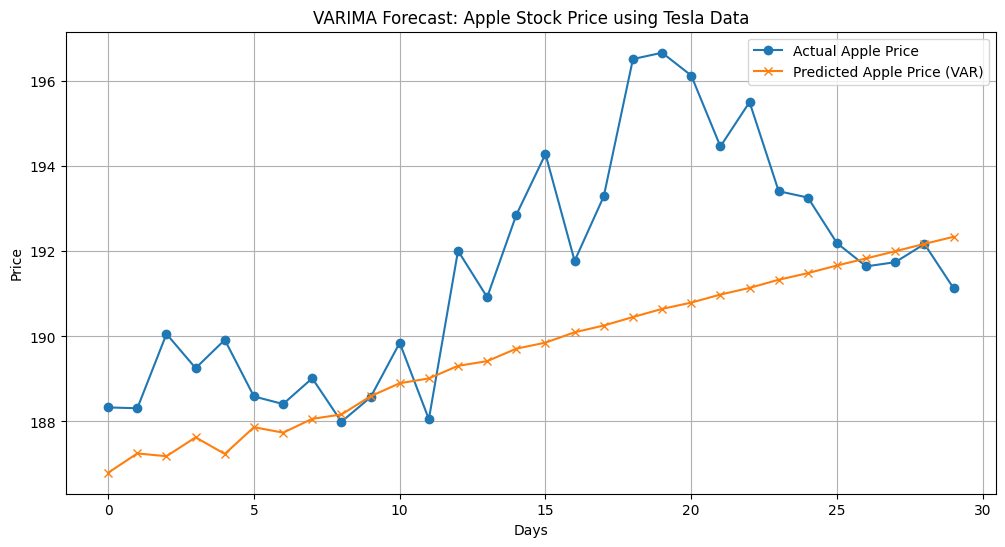

In [ ]:
# Actual Apple prices
actual_apple = combined['y_apple'][-30:].reset_index(drop=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actual_apple, label='Actual Apple Price', marker='o')
plt.plot(forecast_df['y_apple_pred'], label='Predicted Apple Price (VAR)', marker='x')
plt.title('VARIMA Forecast: Apple Stock Price using Tesla Data')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("\n--- Comparison Summary ---")
print(f"Prophet RMSE: {rmse:.4f}")
print(f"ARIMA RMSE  : {rmse_arima:.4f}")
print(f"SARIMA RMSE : {rmse_sarima:.4f}")

# Determine the best fit model based on RMSE
min_rmse = min(rmse, rmse_arima, rmse_sarima)

if min_rmse == rmse:
    best_model = "Prophet"
elif min_rmse == rmse_arima:
    best_model = "ARIMA"
else:
    best_model = "SARIMA"

print(f"\n✅ Best Fit Model (based on RMSE): {best_model}")



--- Comparison Summary ---
Prophet RMSE: 47.6510
ARIMA RMSE  : 48.3213
SARIMA RMSE : 39.5033

✅ Best Fit Model (based on RMSE): SARIMA
